Columns: ['open', 'high', 'low', 'close', 'volume', 'turnover']

=== Normal Backtest Report ===
Pair: BTCUSDT

Performance Metrics:
Total Return                 : 1.4287
Avg Return per Interval      : 0.0008
Std Dev                      : 0.0141
Sharpe Ratio                 : 1.1103
Sortino Ratio                : 0.9703
Calmar Ratio                 : 5.4893
Profit Factor                : 1.3629
Max Drawdown (Abs)           : -0.2603
Max Drawdown Period          : 2024-08-05 00:00:00+00:00 bars
Trade Count                  : 1
Trading Fees                 : 0.0050
Fees Paid                    : 0.0000
Fees / PnL Ratio             : 0.0000
Median Holding Period (bars) : 0.00


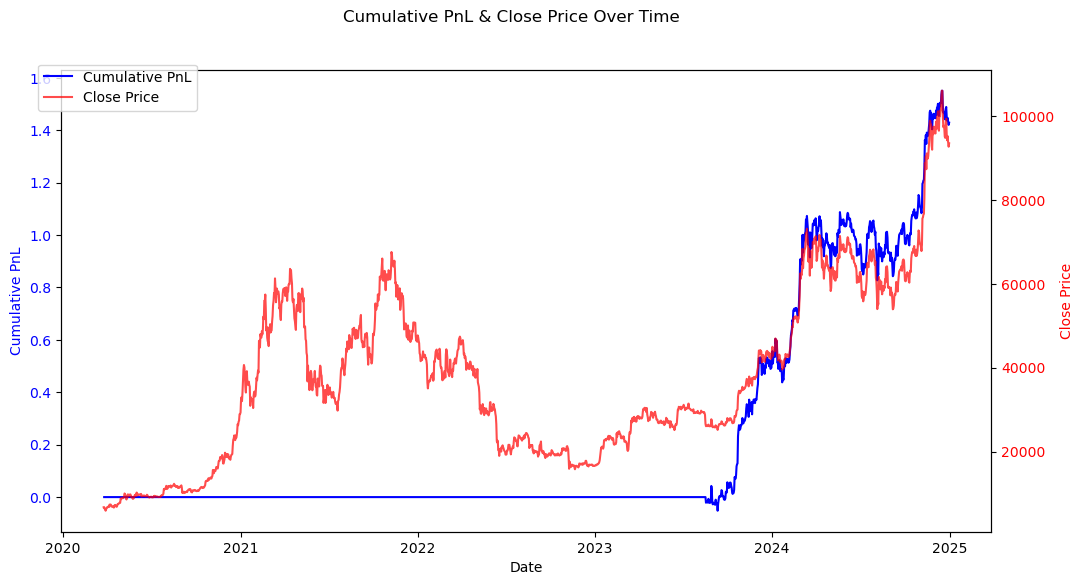

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# ============================================
# 1) Robust Loader
# ============================================
def load_ohlc_csv(path: str) -> pd.DataFrame:
    df = pd.read_csv(path)
    df.columns = df.columns.str.lower()

    # Ensure close
    if 'close' not in df.columns:
        for alt in ('closing_price', 'price', 'last'):
            if alt in df.columns:
                df = df.rename(columns={alt: 'close'})
                break
    if 'close' not in df.columns:
        raise KeyError(f"Required column 'close' not found. Available: {list(df.columns)}")

    # Ensure time
    if 'time' not in df.columns:
        for cand in ('timestamp', 'date', 'datetime'):
            if cand in df.columns:
                df = df.rename(columns={cand: 'time'})
                break
    if 'time' not in df.columns:
        raise KeyError(f"Required column 'time' not found. Available: {list(df.columns)}")

    try:
        df['time'] = pd.to_datetime(df['time'])
    except:
        pass

    return df.set_index('time')


# ============================================
# 2) Indicators (BB + ATR)
# ============================================
def bollinger_bands(df, column='close', window=24, std_dev=1.0):
    mid = df[column].rolling(window=window).mean()
    vol = df[column].rolling(window=window).std()

    df['BB_Middle'] = mid
    df['BB_Upper'] = mid + std_dev * vol
    df['BB_Lower'] = mid - std_dev * vol
    return df


def atr(df: pd.DataFrame, length: int = 14):
    high = df['high']
    low = df['low']
    close = df['close']

    tr = np.maximum(high - low,
                    np.maximum(abs(high - close.shift(1)),
                               abs(low - close.shift(1))))
    df['TR'] = tr
    df['ATR'] = tr.rolling(window=length).mean()
    return df


# ============================================
# 3) Entry Logic (BB + ATR Filter)
# ============================================
def bollinger_band_entry_logic(df: pd.DataFrame, atr_filter: float = 0.0):
    # BB signals
    sig = np.where(df['close'] < df['BB_Lower'], 1,
          np.where(df['close'] > df['BB_Upper'], -1, 0))
    sig = pd.Series(sig, index=df.index)

    # ATR filter: require ATR > X% of price
    if atr_filter > 0:
        condition = df['ATR'] > (atr_filter * df['close'])
        sig = sig.where(condition, 0)

    df['Signal'] = sig.replace(0, np.nan).ffill().fillna(0)
    return df


# ============================================
# 4) Parameter Optimization (PF / SR)
# ============================================
def optimise_param_pf(df):
    best_pf = -np.inf
    best_lookback = -1
    best_std = -1

    for lookback in np.arange(1, 200, 1):
        for std_dev in np.arange(0.5, 5, 0.5):
            tmp = df.copy()

            bollinger_bands(tmp, 'close', lookback, std_dev)
            atr(tmp, 14)
            bollinger_band_entry_logic(tmp)

            tmp['price_chg'] = tmp['close'].pct_change()
            tmp['pnl'] = tmp['Signal'].shift(1) * tmp['price_chg']
            pnl_series = tmp['pnl'].dropna()

            pos = pnl_series[pnl_series > 0].sum()
            neg = pnl_series[pnl_series < 0].abs().sum()

            if pos == 0 or neg == 0:
                continue

            pf = pos / neg
            if pf > best_pf:
                best_pf = pf
                best_lookback = lookback
                best_std = std_dev

    return best_lookback, best_pf, best_std


def optimise_param_sr(df):
    best_sr = -np.inf
    best_lookback = -1
    best_std = -1

    for lookback in np.arange(1, 200, 1):
        for std_dev in np.arange(1, 5, 1):
            tmp = df.copy()

            bollinger_bands(tmp, 'close', lookback, std_dev)
            atr(tmp, 14)
            bollinger_band_entry_logic(tmp)

            tmp['price_chg'] = tmp['close'].pct_change()
            tmp['pnl'] = tmp['Signal'].shift(1) * tmp['price_chg']
            pnl_series = tmp['pnl'].dropna()

            if pnl_series.std() == 0:
                continue

            sr = pnl_series.mean() / pnl_series.std() * np.sqrt(365)

            if sr > best_sr:
                best_sr = sr
                best_lookback = lookback
                best_std = std_dev

    return best_lookback, best_sr, best_std


# ============================================
# 5) RUN BACKTEST
# ============================================
DATA_PATH = "/Users/bryanlew/Document/AlgoCrypto/Backend/Data/bybit_btc_1d_20210101_20241231.csv"

df = load_ohlc_csv(DATA_PATH)
print("Columns:", df.columns.tolist())

OBJECTIVE = 'sr'  # or "pf"

if OBJECTIVE == 'sr':
    best_lookback, best_score, best_std = optimise_param_sr(df)
else:
    best_lookback, best_score, best_std = optimise_param_pf(df)

# Apply final indicators
bollinger_bands(df, 'close', best_lookback, best_std)
atr(df, 14)
bollinger_band_entry_logic(df, atr_filter=0.005)

# Compute returns
df['price_chg'] = df['close'].pct_change()
df['pnl'] = df['Signal'].shift(1) * df['price_chg']
df['cumu_pnl'] = df['pnl'].cumsum()
pnl = df['pnl'].dropna()

# Metrics
pos = pnl[pnl > 0].sum()
neg = pnl[pnl < 0].abs().sum()
pf = pos / neg if neg != 0 else np.nan
sr = pnl.mean() / pnl.std() * np.sqrt(365) if pnl.std() != 0 else np.nan

roi = df['cumu_pnl'].iloc[-1]
max_dd_abs = (df['cumu_pnl'] - df['cumu_pnl'].cummax()).min()
max_dd_period_bars = (df['cumu_pnl'].cummax() - df['cumu_pnl']).idxmax()
total_trades = np.sum(np.diff(df['Signal'].values) != 0)

# Sortino ratio
negative_returns = pnl[pnl < 0]
downside_std = negative_returns.std()
sortino = pnl.mean() / downside_std * np.sqrt(365) if downside_std != 0 else np.nan

# Calmar ratio
calmar = roi / abs(max_dd_abs) if max_dd_abs != 0 else np.nan


# ==========================================================
# 6) YOUR ORIGINAL PRINT SECTION (UNCHANGED)
# ==========================================================
# Fees placeholders (0 unless you model fees)
trading_fees = 0.005
fees_paid = 0.0
fees_pnl_ratio = 0.0 if roi == 0 else fees_paid / abs(roi)

# Pretty report
print("\n=== Normal Backtest Report ===")
print("Pair: BTCUSDT")

print("\nPerformance Metrics:")
print(f"Total Return                 : {roi:.4f}")
print(f"Avg Return per Interval      : {pnl.mean():.4f}")
print(f"Std Dev                      : {pnl.std():.4f}")
print(f"Sharpe Ratio                 : {sr:.4f}")
print(f"Sortino Ratio                : {sortino if not np.isnan(sortino) else 0:.4f}")
print(f"Calmar Ratio                 : {calmar if not np.isnan(calmar) else 0:.4f}")
print(f"Profit Factor                : {pf if not np.isnan(pf) else 0:.4f}")
print(f"Max Drawdown (Abs)           : {max_dd_abs:.4f}")
print(f"Max Drawdown Period          : {max_dd_period_bars} bars")
print(f"Trade Count                  : {total_trades}")
print(f"Trading Fees                 : {trading_fees:.4f}")
print(f"Fees Paid                    : {fees_paid:.4f}")
print(f"Fees / PnL Ratio             : {fees_pnl_ratio:.4f}")
print(f"Median Holding Period (bars) : {0:.2f}")  # If you have calculation, plug here

# Plot
fig, ax1 = plt.subplots(figsize=(12, 6))
ax1.plot(df.index, df['cumu_pnl'], label='Cumulative PnL', color='blue')
ax1.set_xlabel("Date")
ax1.set_ylabel("Cumulative PnL", color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

ax2 = ax1.twinx()
ax2.plot(df.index, df['close'], label='Close Price', color='red', alpha=0.7)
ax2.set_ylabel("Close Price", color='red')
ax2.tick_params(axis='y', labelcolor='red')

fig.suptitle("Cumulative PnL & Close Price Over Time")
fig.legend(loc="upper left", bbox_to_anchor=(0.1, 0.9))
plt.show()
